In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
video_path = '/Users/hyx020222/Documents/GitHub/Passive-Handwriting-Tracking/data/RPReplay_Final1704290401.mov'

In [3]:
def extract_added_black_points(video_path):
    cap = cv2.VideoCapture(video_path)

    # 读取第一帧
    ret, prev_frame = cap.read()
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    added_black_points_sequence = []

    while True:
        # 读取下一帧
        ret, frame = cap.read()
        if not ret:
            break

        # 转换为灰度图
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # 计算相邻帧的差异
        diff = cv2.absdiff(prev_gray, gray)

        # 通过阈值化得到黑点
        _, thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

        # 查找轮廓
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # 提取新增黑点的坐标
        added_points = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 5:  # 考虑面积大于5的轮廓为新增黑点
                M = cv2.moments(contour)
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                added_points.append((cx, cy))

        added_black_points_sequence.append(added_points)

        # 更新上一帧
        prev_gray = gray

    cap.release()
    return added_black_points_sequence

In [4]:
sequence = extract_added_black_points(video_path)
# 删除空时刻
sequence = [points for points in sequence if points]
print(sequence)

[[(285, 130)], [(275, 130)], [(264, 132)], [(252, 135)], [(244, 137)], [(234, 139)], [(225, 142)], [(216, 144)], [(205, 148)], [(199, 151)], [(186, 156)], [(175, 160)], [(166, 165)], [(158, 169)], [(146, 175)], [(143, 178)], [(133, 187)], [(120, 197)], [(112, 205)], [(106, 212)], [(100, 219)], [(90, 233)], [(84, 241)], [(79, 249)], [(75, 257)], [(69, 269)], [(63, 280)], [(60, 288)], [(56, 300)], [(53, 310)], [(52, 319)], [(51, 329)], [(50, 343)], [(50, 353)], [(52, 361)], [(56, 374)], [(59, 382)], [(65, 393)], [(72, 404)], [(79, 415)], [(85, 422)], [(96, 434)], [(103, 442)], [(113, 452)], [(123, 461)], [(140, 474)], [(148, 479)], [(165, 488)], [(186, 497)], [(201, 504)], [(219, 511)], [(238, 519)], [(252, 524)], [(275, 532)], [(295, 539)], [(312, 545)], [(333, 553)], [(352, 560)], [(365, 565)], [(393, 575)], [(414, 583)], [(425, 587)], [(447, 596)], [(468, 607)], [(484, 617)], [(503, 632)], [(523, 648)], [(531, 656)], [(550, 674), (536, 660)], [(559, 685)], [(568, 698)], [(582, 722)], 

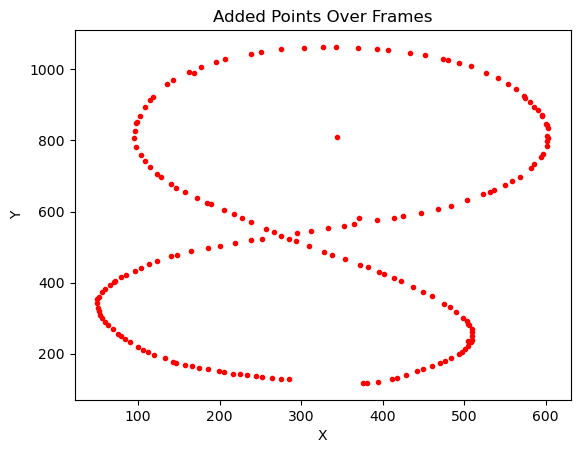

In [5]:
fig, ax = plt.subplots()

for points in sequence:
    if points:  # 检查是否为空
        x, y = zip(*points)
        ax.scatter(x, y, marker='.', color='red')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Added Points Over Frames')

plt.show()